In [ ]:
!pip install biopython

In [ ]:
%pylab inline
import os
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
import matplotlib
from Bio.Seq import Seq
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
factors = ['Olig2', 'LHX2', 'NeuN', 'PU1']
pcols = ["pval_%s"%f for f in factors]
orcols = ["OR_%s"%f for f in factors]
basepath = "/content/gdrive/MyDrive/Figure2/results_extended_coordconv_sliding"

In [ ]:
def compute_confidence_interval(fdata):
    """
    Formula from https://select-statistics.co.uk/calculators/confidence-interval-calculator-odds-ratio/
        a is the number of times both A and B are present,
        b is the number of times A is present, but B is absent,
        c is the number of times A is absent, but B is present, and
        d is the number of times both A and B are negative.
        
        Here, property A: "this kmer" (vs. other kmers)
        property B: high-score (vs. low-score)
        
    To calculate the confidence interval, we use the log odds ratio, log(or) = log(a*d/b*c),
    and calculate its standard error:
        se(log(or)) = √1/a + 1/b + 1/c +1/d

    The confidence interval, ci, is calculated as:
        ci = exp(log(or) ± Zα/2­*√1/a + 1/b + 1/c + 1/d),
    where Zα/2 is the critical value of the Normal distribution at α/2
    (e.g. for a confidence level of 95%, α is 0.05 and the critical value is 1.96).
    """
    ci = fdata[["kmer",]]
    mult = 1.96
    for i in range(len(factors)):
        n_pos_ttl = fdata["n_pos_%s"%factors[i]].sum()
        n_ttl = fdata["n_ttl_%s"%factors[i]].sum()
        a = fdata["n_pos_%s"%factors[i]]
        b = fdata["n_ttl_%s"%factors[i]] - fdata["n_pos_%s"%factors[i]]
        c = n_pos_ttl - fdata["n_pos_%s"%factors[i]]
        d = n_ttl - a - b - c
        
        log_or = np.log((a*d)/(b*c))
        se_log_or = (1/a + 1/b + 1/c + 1/d) ** (0.5)
        ci["ci_upper_%s"%factors[i]] = np.exp(log_or + mult*se_log_or)
        ci["ci_lower_%s"%factors[i]] = np.exp(log_or - mult*se_log_or)
    return ci

def LoadKmer(fpath, OR_threshold):
    max_kmers = []
    fdata = pd.DataFrame()
    for i in range(len(factors)):
        ff = pd.read_csv(fpath%factors[i], sep="\t", usecols=[0,1,2,4,5],
                         names=["kmer","pval_%s"%factors[i],"OR_%s"%factors[i],
                               "n_ttl_%s"%factors[i], "n_pos_%s"%factors[i]])
        canonical_lst = []
        for km in ff["kmer"]:
          rc_km = str(Seq(km).reverse_complement())
          if rc_km < km:
            canonical_lst.append(rc_km)
          else:
            canonical_lst.append(km)
        ff["canonical_kmer"] = canonical_lst
        ff = ff.groupby(by="canonical_kmer").agg({"pval_%s"%factors[i]:'min', 
                                                  "OR_%s"%factors[i]:'max', 
                                                  "n_ttl_%s"%factors[i]:'sum', 
                                                  "n_pos_%s"%factors[i]:'sum'})
        ff["kmer"] = ff.index

        if fdata.empty:
            fdata = ff
        else:
            fdata = pd.merge(ff, fdata, on=["kmer"], how="right")
        # print("Fdata:",fdata)
        for val_idx in range(1):
            max_kmers.append(ff.sort_values("OR_%s"%factors[i], ascending=False)["kmer"].values[val_idx])
            
    ci = compute_confidence_interval(fdata)
    max_kmers = set(max_kmers)
    ORdata = pd.merge(fdata, ci, on=["kmer"], how="right")
    ORdata.index = ORdata["kmer"]

    max_kmers = max_kmers.union(set(ORdata["kmer"][ORdata[orcols].apply(max, 1)>OR_threshold]))
    return ORdata, ci, max_kmers

def GetPvalSize(x, numtests, pthresh):
    # print(numtests)
    if x < 1e-5: return 100
    # elif x < pthresh : return 50
    else: return max(10,-np.log10(x)/5*100)
    
def value_to_color(val, minval, maxval, palette, n_colors):
    if val < minval: val = minval
    if val > maxval: val = maxval
    val_position = float((val - minval)) / (maxval - minval) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

def GetPSig(pval):
    if pval<0.01: return 1
    else: return 0
    
def heatmap(ORmatrix, Pmatrix, outprefix, x_labels=None, y_labels=None, pthresh=0.01, color_min_val=0, color_max_val=6):
    # sns heatmap
    score_matrix = np.zeros(ORmatrix.shape)
    for i in range(ORmatrix.shape[0]):
        for j in range(ORmatrix.shape[1]):
            score_matrix[i,j] = ORmatrix.iloc[i,j]*(GetPSig(Pmatrix.iloc[i,j]))
            
    g = sns.clustermap(pd.DataFrame(score_matrix, index=ORmatrix.index, columns=ORmatrix.columns), yticklabels=True)
    g.savefig("%s-heatmap.pdf"%outprefix)
    
    # fancy heatmap
    ORmatrix_reorder = ORmatrix#.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_col.reordered_ind]
    ORmatrix_melt = pd.melt(ORmatrix_reorder)
    ORmatrix_melt["kmer"] = list(ORmatrix_reorder.index)*ORmatrix_reorder.shape[1]
    ORmatrix_melt["variable"] = ORmatrix_melt["variable"].apply(lambda x: x.replace("OR_",""))

    Pmatrix_reorder = Pmatrix#.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_col.reordered_ind]
    Pmatrix_melt = pd.melt(Pmatrix_reorder)
    Pmatrix_melt["kmer"] = list(Pmatrix_reorder.index)*Pmatrix_reorder.shape[1]
    Pmatrix_melt["variable"] = Pmatrix_melt["variable"].apply(lambda x: x.replace("p_",""))
    
    # Set x and y coords
    if x_labels is None or y_labels is None:
        x_labels = [item.replace("OR_","") for item in ORmatrix_reorder.columns]
        y_labels = list(ORmatrix_reorder.index)
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)}

    # Get size, relative to pval
    size = np.array(Pmatrix_melt["value"].apply(lambda x: GetPvalSize(x, ORmatrix_melt.shape[0], pthresh)))
    
    # Get color data
    n_colors = 256 # Use 256 colors for the diverging color palette
    palette = sns.color_palette("YlGnBu", n_colors)
    color_min, color_max = [color_min_val, color_max_val]
    
    # Plot
    size_scale = 1
    fig, ax = plt.subplots()
    fig.set_size_inches((20,2.5))
    ax.scatter(
        y = ORmatrix_melt["variable"].map(x_to_num),
        x = ORmatrix_melt["kmer"].map(y_to_num),
        marker='s',
        s = size*size_scale,
        c = ORmatrix_melt["value"].apply(lambda x: value_to_color(x, color_min, color_max, palette, n_colors)), # Vector of square color values, mapped to color palette
    )
    
    # Show column labels on the axes
    ax.set_yticks([x_to_num[v] for v in x_labels])
    ax.set_yticklabels(x_labels, size=8)
    ax.set_xticks([y_to_num[v] for v in y_labels])
    ax.set_xticklabels(y_labels, size=10, rotation=90)
    #ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    plt.tight_layout()
    fig.savefig("%s-fancy-heatmap.pdf"%outprefix)
    # print("%s-fancy-heatmap.pdf"%outprefix)
    plt.show()
    plt.close()

    # color bar
    fig, ax = plt.subplots()
    fig.set_size_inches((0.3,3))
    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    #ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right
    plt.show()

    return x_labels, y_labels

In [ ]:
select_motifs = ['NFIA', 'RFX', 'SOX', 'TFAP4', 'ETV', 'ETS', 'ELF', 'SPI1', 'IRF', 
                 'CEBP', 'MEF2', 'NEURO', 'JUN', 'FOS', 'JDP2']
exclude_kmers = ['AATAGA','AATAGC']
def draw_heatmap(fpath, outprefix, OR_threshold):
    ORdata, conf, max_kmers = LoadKmer(fpath, OR_threshold)
    print (len(max_kmers))
    
    #Load TOMTOM aligned motifs
    motif_lst = []
    for km in ORdata.index:
      if km in align_df.index:
        tmp = []
        for a in align_df.loc[[km],'Target_ID']:
          if a in motif_dict:
            tmp.append(motif_dict[a])
        motif_lst.append('|'.join(tmp))
      else:
        motif_lst.append(km)
    ORdata["motif"] = motif_lst

    ###The heatmap  kmers, all, proximal, distal ###
    # Using unified kmer list
    df = ORdata.copy()
    df.index = df["kmer"]
    df = df[df["kmer"].apply(lambda x: x in max_kmers)]
    df['motif'] = ['|'.join(m.split('|')[:8])+('|..')*(len(m.split('|'))>8) for m in df["motif"]]
    select_kmers = []
    for m in select_motifs:
      for n in range(len(df)):
        cur_km = df['kmer'][n]
        if m in df['motif'][n].upper() and cur_km not in select_kmers and cur_km not in exclude_kmers:
          select_kmers.append(cur_km)
    print(len(select_kmers))
    df = df.loc[select_kmers]
    # df.index = ['|'.join(m.split('|')[:2])+('|..'+str(len(m.split('|')))+'more..')*(len(m.split('|'))>3) for m in df["motif"]]
    print(df)
    # OUTDIR = "./"
    xlabs, ylabs = heatmap(
        ORmatrix=df[orcols],
        Pmatrix=df[pcols],
        outprefix=outprefix,
        color_min_val=0, color_max_val=OR_threshold*2,
    )
    print(len(ylabs))

    return df

In [ ]:
motif_dict = {}
with open("/content/gdrive/MyDrive/Alzheimer_DL_project/JASPAR2022_CORE_non-redundant_pfms_jaspar.txt", "r") as rf:
  for line in rf:
    if line[0] == ">":
      motif_dict[line[1:].split("\t")[0]] = line[:-1].split("\t")[-1]

align_file = "/content/gdrive/MyDrive/Alzheimer_DL_project/tomtom_6mer.tsv"
align_df = pd.read_csv(align_file, sep='\t', index_col=0)
align_df = align_df.iloc[:-3]
align_df.head()

,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
Query_ID,,,,,,,,,
AAAAAA,MA1125.1,4.0,6.790830e-07,0.000488,0.000977,6.0,AAAAAA,TTTAAAAAAAAA,+
AAAAAT,MA0497.1,5.0,6.397330e-04,0.459968,0.264623,6.0,AAAAAT,ATGCTAAAAATAGAA,+
AAAAAT,MA0052.2,4.0,6.893150e-04,0.495618,0.264623,6.0,AAAAAT,AGCTAAAAATAGCAT,+
AAAAAT,MA0052.3,3.0,7.573490e-04,0.544534,0.264623,6.0,AAAAAT,TCTAAAAATAGA,+
AAAAAT,MA0773.1,3.0,7.573490e-04,0.544534,0.264623,6.0,AAAAAT,ACTATAAATAGA,+


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


305
95
            pval_PU1  ...                                              motif
kmer                  ...                                                   
ATGCCA  1.000000e+00  ...                  NFIA|Hic1|NFIC|CREB3L1|NFIC::TLX1
ATTGGC  2.153534e-06  ...                     NFIA|NFYA|NFIC::TLX1|E2F7|NFIX
CCAAGG  1.000000e+00  ...                  ESRRB|NFIC|Esrrg|NFIA|NR1H2::RXRA
CGCCAA  9.547456e-01  ...           E2F7|E2F1|NFIC::TLX1|NFIA|NFIX|EGR2|NFIC
CTGCCA  1.000000e+00  ...  NFIA|NFIC::TLX1|NFIC|MEIS2|CREB3L1|Hic1|TGIF1|...
...              ...  ...                                                ...
GATTCA  8.565183e-02  ...  JDP2|FOS|NFE2|FOSL2|FOSL2::JUNB|FOSL2::JUND|FO...
AATCAT  1.522925e-11  ...        HNF1B|JDP2|HNF1A|NFE2|DUX4|PBX1|FOS|NFYA|..
ATGAAT  8.502134e-01  ...                                ZNF24|JDP2|NFE2|FOS
CGTCAC  6.437042e-01  ...       PAX9|JDP2|Atf1|Creb5|CREB3|PAX1|XBP1|ATF7|..
GTCATA  1.275769e-11  ...  JDP2|ATF7|Creb5|ESRRB|RARA|JDP2|NFE2|NR1H2

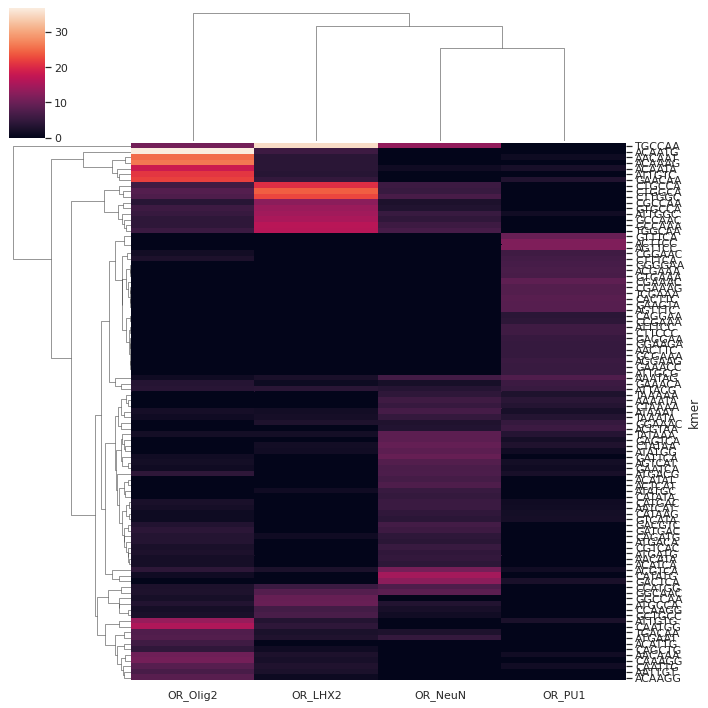

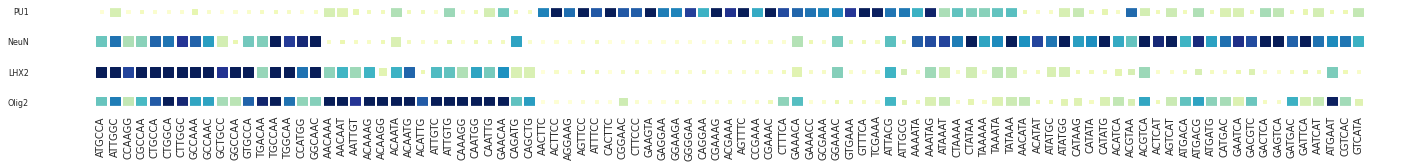

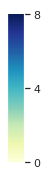

95


In [ ]:
fpath = os.path.join(basepath, "%s/kmer_ranking_6mer.txt")
OUTDIR = "/content/gdrive/MyDrive/Alzheimer_DL_project/"
outprefix=os.path.join(OUTDIR, "allsites_6mer")
draw_df = draw_heatmap(fpath, outprefix, OR_threshold=4)

In [ ]:
# draw_df.loc[draw_df['kmer'] == 'AATTAG', pcols+orcols]
draw_df.loc[['RUN' in m.upper() for m in draw_df['motif']], pcols+orcols+['motif']]

,pval_Olig2,pval_LHX2,pval_NeuN,pval_PU1,OR_Olig2,OR_LHX2,OR_NeuN,OR_PU1,motif
kmer,,,,,,,,,


In [ ]:
select_kmers = []
for m in select_motifs:
  print(m)
  for n in range(len(draw_df)):
    cur_km = draw_df['kmer'][n]
    if m in draw_df['motif'][n].upper() and cur_km not in select_kmers:
      select_kmers.append(cur_km)
      print(cur_km)
print(len(select_kmers))

NFIA
ATGCCA
ATTGGC
CCAAGG
CGCCAA
CTGCCA
CTGGCA
CTTGGC
GCCAAA
GCCAAC
GCTGCC
GGCCAA
GTGCCA
TGACAA
TGCCAA
TGGCAA
RFX
CCATGG
GGCAAC
SOX
AACAAA
AACAAT
AATTGT
ACAAAG
ACAAGG
ACAATA
ACAATG
ACATTG
ATTGTC
ATTGTG
CAAAGG
CAATGG
CAATTG
GAACAA
TFAP4
CAGATG
CAGCTG
ETV
AACTTC
ACTTCC
AGGAAG
AGTTCC
ATTTCC
CACTTC
CGGAAC
CTTCCC
GAAGTA
GAGGAA
GGAAGA
GGGGAA
ETS
ELF
CAGGAA
CGAAAG
SPI1
IRF
ACGAAA
AGTTTC
CCGAAA
CGAAAC
CTTTCA
GAAACA
GAAACC
GCGAAA
GGAAAC
GTGAAA
GTTTCA
TCGAAA
CEBP
ATTACG
ATTGCG
MEF2
AAAATA
AAATAG
ATAAAT
CTAAAA
CTATAA
TAAAAA
TAAATA
TATAAA
NEURO
AACATA
ACATAT
ATATGC
ATATGG
CATAAG
CATATA
CATATG
JUN
ACATCA
ACGTAA
ACGTCA
ACTCAT
AGTCAT
ATGACA
ATGACG
ATGATG
CATGAC
GAATCA
GACGTC
GACTCA
GAGTCA
GATGAC
GATTCA
FOS
AATCAT
ATGAAT
JDP2
CGTCAC
GTCATA
95


In [ ]:
fpath = os.path.join(basepath, "%s/kmer_ranking.txt")
OUTDIR = "/content/gdrive/MyDrive/Alzheimer_DL_project/"
outprefix=os.path.join(OUTDIR, "allsites_5mers")
print(outprefix)
draw_heatmap(fpath, outprefix, OR_threshold=2)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


195


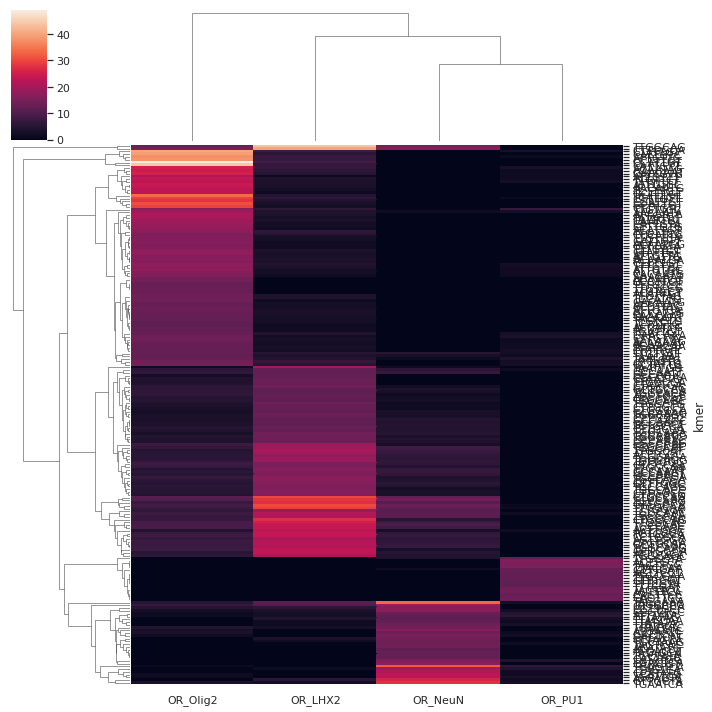

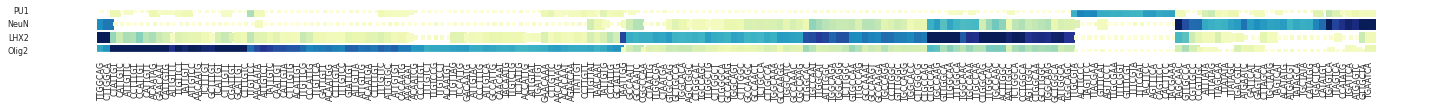

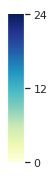

195


In [ ]:
fpath = os.path.join(basepath, "%s/kmer_ranking_7mer.txt")
outprefix=os.path.join(OUTDIR, "allsites_7mer")
draw_heatmap(fpath, outprefix, OR_threshold=12)